# Mask R-CNN - Train on Potato Dataset


This notebook shows how to train Mask R-CNN on your own dataset.


In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.visualize import display_images

from samples.potato import potato

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "model_weights/mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


### Configurations

In [2]:
POTATO_DIR = os.path.join(ROOT_DIR, "datasets/POTATO_V21")

config = Config()
# Override the training configurations with a few
# changes for inferencing.
class PotatoConfig(config.__class__):
    # Run detection on one image at a time


    NAME = "potato"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 3
    
    
     # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes
    
    
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    BACKBONE_STRIDES = [4,8,16,32,64]
    
    ##********** 1)ANCHORS GENERATION - for RPN*********
    
    #     Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (8, 16, 24,32, 48) 
    TOP_DOWN_PYRAMID_SIZE = 256
    
    ##********** 2)PROPOSAL LAYER ********* (no deep learning involved here)
    
     # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 128 ##in dataset generation

    ## tf.image.non_max_suppression(boxes,scores,max_output_size,iou_threshold=0.5,...)
    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD=0.7
    #A float representing the threshold for deciding whether boxes overlap too much with respect to IOU.    
    ## POST_NMS_ROIS_TRAINING~ POST_NMS_ROIS_INFERENCE ~proposal_count ~ max_output_size
    
    POST_NMS_ROIS_TRAINING=1500
    POST_NMS_ROIS_INFERENCE=800
    ##********** 3a)TRAINING - DETECTION TARGET LAYER *********
    
    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 128
    
    
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 128
    # Percent of positive ROIs used to train classifier/mask heads
    ROI_POSITIVE_RATIO = 0.33
    
    ##********** 3B)INFERENCE - DETECTION  LAYER *********

    
    # Non-maximum suppression threshold for detection in DetectionLater
    DETECTION_NMS_THRESHOLD = 0.5  # 0.5 above iou_threshold

    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped in DetectionLater
    DETECTION_MIN_CONFIDENCE = 0.7

    # Max number of final detections
    DETECTION_MAX_INSTANCES = 120

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 40

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 6
    LEARNING_RATE = 0.001

    TRAIN_BN = False

    
    
config = PotatoConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     3
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        120
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.5
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 3
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    Configurations:

    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset



In [4]:

# Training dataset
dataset_train = potato.PotatoDataset()
dataset_train.load_potato(POTATO_DIR, "train")
dataset_train.prepare()
print('Training images: {}'.format(len(dataset_train.image_ids)))
# Validation dataset
dataset_val= potato.PotatoDataset()
dataset_val.load_potato(POTATO_DIR, "val")
dataset_val.prepare()
print('Validation images: {}'.format(len(dataset_val.image_ids)))


Training images: 99
Validation images: 25


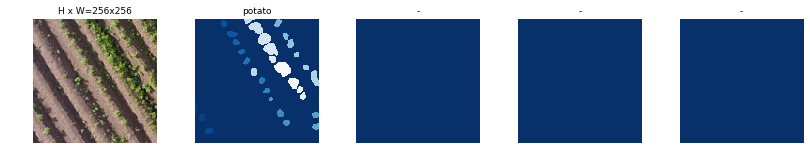

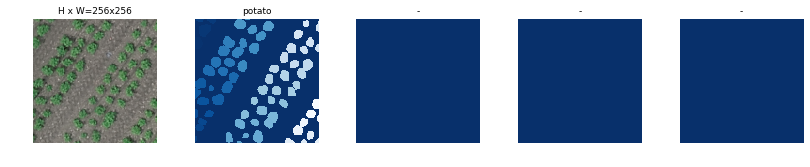

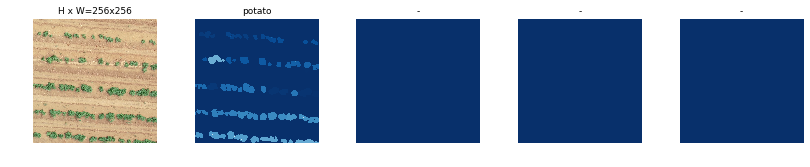

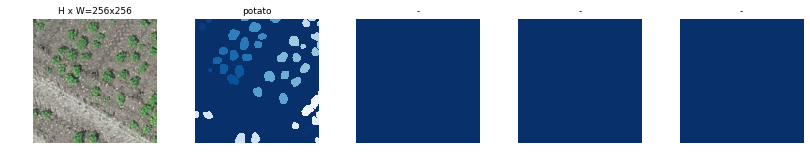

In [5]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [6]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
# Which weights to start with?
init_with = "retrain"  # imagenet, coco,last, retrain
model_path_retrain = 'path/to/model.h5'

retrain_learning_rate = config.LEARNING_RATE

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
    
elif init_with == 'retrain':
    print("Loading weights from ", model_path_retrain)
    model.load_weights(model_path_retrain, by_name=True)
    config.LEARNING_RATE = retrain_learning_rate
    
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)


Loading weights from  /home/melissande/Desktop/git_repositories/Mask_RCNN/model_weights/potato_2_training_best_model/model.h5


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [8]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.


import imgaug


augmentation = imgaug.augmenters.Sometimes(0.5, [
                    imgaug.augmenters.Fliplr(0.5),
                    imgaug.augmenters.Rot90(1),
#                     imgaug.augmenters.GaussianBlur(sigma=(0.0, 5.0))
                ])

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            augmentation=augmentation,
            epochs=600, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/melissande/Desktop/git_repositories/Mask_RCNN/logs/potato20190824T1531/mask_rcnn_potato_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4     

/home/melissande/hb/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/melissande/hb/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/600
40/40 [==============================] - 156s 4s/step - loss: 2.2926 - rpn_class_loss: 0.3735 - rpn_bbox_loss: 0.6790 - mrcnn_class_loss: 0.3846 - mrcnn_bbox_loss: 0.4209 - mrcnn_mask_loss: 0.4345 - val_loss: 2.0098 - val_rpn_class_loss: 0.2749 - val_rpn_bbox_loss: 0.6805 - val_mrcnn_class_loss: 0.3147 - val_mrcnn_bbox_loss: 0.3481 - val_mrcnn_mask_loss: 0.3917
Epoch 2/600
40/40 [==============================] - 42s 1s/step - loss: 2.5402 - rpn_class_loss: 0.3940 - rpn_bbox_loss: 0.7138 - mrcnn_class_loss: 0.4959 - mrcnn_bbox_loss: 0.4523 - mrcnn_mask_loss: 0.4841 - val_loss: 1.9806 - val_rpn_class_loss: 0.2901 - val_rpn_bbox_loss: 0.7262 - val_mrcnn_class_loss: 0.2453 - val_mrcnn_bbox_loss: 0.3196 - val_mrcnn_mask_loss: 0.3993
Epoch 3/600
40/40 [==============================] - 42s 1s/step - loss: 2.5383 - rpn_class_loss: 0.3807 - rpn_bbox_loss: 0.6530 - mrcnn_class_loss: 0.5351 - mrcnn_bbox_loss: 0.4827 - mrcnn_mask_loss: 0.4867 - val_loss: 2.6437 - val_rpn_class_loss: 

Epoch 23/600
40/40 [==============================] - 43s 1s/step - loss: 1.9205 - rpn_class_loss: 0.2453 - rpn_bbox_loss: 0.4695 - mrcnn_class_loss: 0.4434 - mrcnn_bbox_loss: 0.3515 - mrcnn_mask_loss: 0.4108 - val_loss: 1.4354 - val_rpn_class_loss: 0.1840 - val_rpn_bbox_loss: 0.5446 - val_mrcnn_class_loss: 0.2054 - val_mrcnn_bbox_loss: 0.2203 - val_mrcnn_mask_loss: 0.2811
Epoch 24/600
40/40 [==============================] - 45s 1s/step - loss: 1.8953 - rpn_class_loss: 0.2547 - rpn_bbox_loss: 0.4802 - mrcnn_class_loss: 0.4263 - mrcnn_bbox_loss: 0.3423 - mrcnn_mask_loss: 0.3918 - val_loss: 1.4500 - val_rpn_class_loss: 0.1970 - val_rpn_bbox_loss: 0.5281 - val_mrcnn_class_loss: 0.2469 - val_mrcnn_bbox_loss: 0.1985 - val_mrcnn_mask_loss: 0.2795
Epoch 25/600
40/40 [==============================] - 44s 1s/step - loss: 2.4570 - rpn_class_loss: 0.3764 - rpn_bbox_loss: 0.5940 - mrcnn_class_loss: 0.5169 - mrcnn_bbox_loss: 0.4761 - mrcnn_mask_loss: 0.4935 - val_loss: 1.8903 - val_rpn_class_loss

Epoch 45/600
40/40 [==============================] - 45s 1s/step - loss: 1.8763 - rpn_class_loss: 0.2363 - rpn_bbox_loss: 0.4709 - mrcnn_class_loss: 0.4088 - mrcnn_bbox_loss: 0.3544 - mrcnn_mask_loss: 0.4059 - val_loss: 1.4579 - val_rpn_class_loss: 0.1756 - val_rpn_bbox_loss: 0.4712 - val_mrcnn_class_loss: 0.3133 - val_mrcnn_bbox_loss: 0.2098 - val_mrcnn_mask_loss: 0.2879
Epoch 46/600
40/40 [==============================] - 43s 1s/step - loss: 1.7458 - rpn_class_loss: 0.2285 - rpn_bbox_loss: 0.4215 - mrcnn_class_loss: 0.3913 - mrcnn_bbox_loss: 0.3158 - mrcnn_mask_loss: 0.3887 - val_loss: 1.4782 - val_rpn_class_loss: 0.1974 - val_rpn_bbox_loss: 0.4790 - val_mrcnn_class_loss: 0.2805 - val_mrcnn_bbox_loss: 0.2254 - val_mrcnn_mask_loss: 0.2958
Epoch 47/600
40/40 [==============================] - 43s 1s/step - loss: 2.0196 - rpn_class_loss: 0.2899 - rpn_bbox_loss: 0.5016 - mrcnn_class_loss: 0.4654 - mrcnn_bbox_loss: 0.3579 - mrcnn_mask_loss: 0.4048 - val_loss: 1.3886 - val_rpn_class_loss

Epoch 67/600
40/40 [==============================] - 49s 1s/step - loss: 1.3935 - rpn_class_loss: 0.1589 - rpn_bbox_loss: 0.3837 - mrcnn_class_loss: 0.3086 - mrcnn_bbox_loss: 0.2396 - mrcnn_mask_loss: 0.3027 - val_loss: 1.4019 - val_rpn_class_loss: 0.1412 - val_rpn_bbox_loss: 0.4542 - val_mrcnn_class_loss: 0.2553 - val_mrcnn_bbox_loss: 0.2480 - val_mrcnn_mask_loss: 0.3032
Epoch 68/600
40/40 [==============================] - 45s 1s/step - loss: 1.8267 - rpn_class_loss: 0.2449 - rpn_bbox_loss: 0.4608 - mrcnn_class_loss: 0.3708 - mrcnn_bbox_loss: 0.3562 - mrcnn_mask_loss: 0.3940 - val_loss: 1.3495 - val_rpn_class_loss: 0.1446 - val_rpn_bbox_loss: 0.4395 - val_mrcnn_class_loss: 0.2322 - val_mrcnn_bbox_loss: 0.2411 - val_mrcnn_mask_loss: 0.2922
Epoch 69/600
40/40 [==============================] - 42s 1s/step - loss: 2.1175 - rpn_class_loss: 0.3268 - rpn_bbox_loss: 0.5129 - mrcnn_class_loss: 0.4365 - mrcnn_bbox_loss: 0.4016 - mrcnn_mask_loss: 0.4396 - val_loss: 1.3025 - val_rpn_class_loss

Epoch 89/600
40/40 [==============================] - 43s 1s/step - loss: 2.2513 - rpn_class_loss: 0.3172 - rpn_bbox_loss: 0.5221 - mrcnn_class_loss: 0.5190 - mrcnn_bbox_loss: 0.4289 - mrcnn_mask_loss: 0.4641 - val_loss: 1.4985 - val_rpn_class_loss: 0.1568 - val_rpn_bbox_loss: 0.3987 - val_mrcnn_class_loss: 0.3066 - val_mrcnn_bbox_loss: 0.2921 - val_mrcnn_mask_loss: 0.3443
Epoch 90/600
40/40 [==============================] - 42s 1s/step - loss: 1.4635 - rpn_class_loss: 0.1560 - rpn_bbox_loss: 0.3481 - mrcnn_class_loss: 0.3259 - mrcnn_bbox_loss: 0.2769 - mrcnn_mask_loss: 0.3566 - val_loss: 1.4917 - val_rpn_class_loss: 0.1487 - val_rpn_bbox_loss: 0.3975 - val_mrcnn_class_loss: 0.3394 - val_mrcnn_bbox_loss: 0.2793 - val_mrcnn_mask_loss: 0.3268
Epoch 91/600
40/40 [==============================] - 42s 1s/step - loss: 2.3026 - rpn_class_loss: 0.3365 - rpn_bbox_loss: 0.5719 - mrcnn_class_loss: 0.4791 - mrcnn_bbox_loss: 0.4480 - mrcnn_mask_loss: 0.4671 - val_loss: 1.3959 - val_rpn_class_loss

Epoch 111/600
40/40 [==============================] - 43s 1s/step - loss: 1.4548 - rpn_class_loss: 0.1648 - rpn_bbox_loss: 0.3520 - mrcnn_class_loss: 0.3188 - mrcnn_bbox_loss: 0.2737 - mrcnn_mask_loss: 0.3454 - val_loss: 1.1842 - val_rpn_class_loss: 0.0938 - val_rpn_bbox_loss: 0.3724 - val_mrcnn_class_loss: 0.2183 - val_mrcnn_bbox_loss: 0.2188 - val_mrcnn_mask_loss: 0.2809
Epoch 112/600
40/40 [==============================] - 43s 1s/step - loss: 1.4675 - rpn_class_loss: 0.1781 - rpn_bbox_loss: 0.3507 - mrcnn_class_loss: 0.3150 - mrcnn_bbox_loss: 0.2732 - mrcnn_mask_loss: 0.3504 - val_loss: 1.1758 - val_rpn_class_loss: 0.0929 - val_rpn_bbox_loss: 0.3563 - val_mrcnn_class_loss: 0.2342 - val_mrcnn_bbox_loss: 0.2181 - val_mrcnn_mask_loss: 0.2742
Epoch 113/600
40/40 [==============================] - 44s 1s/step - loss: 1.8359 - rpn_class_loss: 0.1925 - rpn_bbox_loss: 0.4282 - mrcnn_class_loss: 0.4465 - mrcnn_bbox_loss: 0.3611 - mrcnn_mask_loss: 0.4076 - val_loss: 1.5027 - val_rpn_class_l

Epoch 133/600
40/40 [==============================] - 43s 1s/step - loss: 2.2484 - rpn_class_loss: 0.2372 - rpn_bbox_loss: 0.5379 - mrcnn_class_loss: 0.5566 - mrcnn_bbox_loss: 0.4460 - mrcnn_mask_loss: 0.4707 - val_loss: 1.4350 - val_rpn_class_loss: 0.1539 - val_rpn_bbox_loss: 0.4601 - val_mrcnn_class_loss: 0.2818 - val_mrcnn_bbox_loss: 0.2379 - val_mrcnn_mask_loss: 0.3015
Epoch 134/600
40/40 [==============================] - 43s 1s/step - loss: 1.4857 - rpn_class_loss: 0.1910 - rpn_bbox_loss: 0.3884 - mrcnn_class_loss: 0.2993 - mrcnn_bbox_loss: 0.2642 - mrcnn_mask_loss: 0.3428 - val_loss: 1.2348 - val_rpn_class_loss: 0.1299 - val_rpn_bbox_loss: 0.4173 - val_mrcnn_class_loss: 0.2145 - val_mrcnn_bbox_loss: 0.2156 - val_mrcnn_mask_loss: 0.2576
Epoch 135/600
40/40 [==============================] - 42s 1s/step - loss: 1.1836 - rpn_class_loss: 0.1338 - rpn_bbox_loss: 0.2942 - mrcnn_class_loss: 0.2462 - mrcnn_bbox_loss: 0.2163 - mrcnn_mask_loss: 0.2931 - val_loss: 1.1792 - val_rpn_class_l

Epoch 155/600
40/40 [==============================] - 43s 1s/step - loss: 1.8339 - rpn_class_loss: 0.2406 - rpn_bbox_loss: 0.4552 - mrcnn_class_loss: 0.4030 - mrcnn_bbox_loss: 0.3425 - mrcnn_mask_loss: 0.3926 - val_loss: 1.3718 - val_rpn_class_loss: 0.1191 - val_rpn_bbox_loss: 0.3785 - val_mrcnn_class_loss: 0.2581 - val_mrcnn_bbox_loss: 0.2806 - val_mrcnn_mask_loss: 0.3356
Epoch 156/600
40/40 [==============================] - 43s 1s/step - loss: 1.6853 - rpn_class_loss: 0.2008 - rpn_bbox_loss: 0.4104 - mrcnn_class_loss: 0.3688 - mrcnn_bbox_loss: 0.3290 - mrcnn_mask_loss: 0.3762 - val_loss: 1.3303 - val_rpn_class_loss: 0.1362 - val_rpn_bbox_loss: 0.3377 - val_mrcnn_class_loss: 0.2791 - val_mrcnn_bbox_loss: 0.2683 - val_mrcnn_mask_loss: 0.3090
Epoch 157/600
40/40 [==============================] - 43s 1s/step - loss: 1.4543 - rpn_class_loss: 0.1627 - rpn_bbox_loss: 0.3515 - mrcnn_class_loss: 0.3018 - mrcnn_bbox_loss: 0.2854 - mrcnn_mask_loss: 0.3529 - val_loss: 1.1924 - val_rpn_class_l

Epoch 177/600
40/40 [==============================] - 43s 1s/step - loss: 2.2604 - rpn_class_loss: 0.3121 - rpn_bbox_loss: 0.5328 - mrcnn_class_loss: 0.4947 - mrcnn_bbox_loss: 0.4408 - mrcnn_mask_loss: 0.4801 - val_loss: 1.3898 - val_rpn_class_loss: 0.1191 - val_rpn_bbox_loss: 0.3732 - val_mrcnn_class_loss: 0.3394 - val_mrcnn_bbox_loss: 0.2467 - val_mrcnn_mask_loss: 0.3114
Epoch 178/600
40/40 [==============================] - 42s 1s/step - loss: 1.4951 - rpn_class_loss: 0.1273 - rpn_bbox_loss: 0.3633 - mrcnn_class_loss: 0.3437 - mrcnn_bbox_loss: 0.3002 - mrcnn_mask_loss: 0.3606 - val_loss: 1.0199 - val_rpn_class_loss: 0.0839 - val_rpn_bbox_loss: 0.3339 - val_mrcnn_class_loss: 0.1918 - val_mrcnn_bbox_loss: 0.1693 - val_mrcnn_mask_loss: 0.2410
Epoch 179/600
40/40 [==============================] - 42s 1s/step - loss: 1.5259 - rpn_class_loss: 0.1935 - rpn_bbox_loss: 0.3559 - mrcnn_class_loss: 0.3368 - mrcnn_bbox_loss: 0.2832 - mrcnn_mask_loss: 0.3565 - val_loss: 1.0739 - val_rpn_class_l

Epoch 199/600
40/40 [==============================] - 43s 1s/step - loss: 1.7570 - rpn_class_loss: 0.3060 - rpn_bbox_loss: 0.4018 - mrcnn_class_loss: 0.3641 - mrcnn_bbox_loss: 0.3094 - mrcnn_mask_loss: 0.3757 - val_loss: 1.2575 - val_rpn_class_loss: 0.1610 - val_rpn_bbox_loss: 0.4069 - val_mrcnn_class_loss: 0.1906 - val_mrcnn_bbox_loss: 0.2190 - val_mrcnn_mask_loss: 0.2800
Epoch 200/600
40/40 [==============================] - 44s 1s/step - loss: 1.5294 - rpn_class_loss: 0.1845 - rpn_bbox_loss: 0.3756 - mrcnn_class_loss: 0.3330 - mrcnn_bbox_loss: 0.2820 - mrcnn_mask_loss: 0.3542 - val_loss: 1.4184 - val_rpn_class_loss: 0.1786 - val_rpn_bbox_loss: 0.4364 - val_mrcnn_class_loss: 0.2648 - val_mrcnn_bbox_loss: 0.2543 - val_mrcnn_mask_loss: 0.2844
Epoch 201/600
40/40 [==============================] - 43s 1s/step - loss: 1.6681 - rpn_class_loss: 0.2448 - rpn_bbox_loss: 0.3968 - mrcnn_class_loss: 0.3427 - mrcnn_bbox_loss: 0.3008 - mrcnn_mask_loss: 0.3829 - val_loss: 1.2465 - val_rpn_class_l

Epoch 221/600
40/40 [==============================] - 42s 1s/step - loss: 1.6360 - rpn_class_loss: 0.1935 - rpn_bbox_loss: 0.3946 - mrcnn_class_loss: 0.3638 - mrcnn_bbox_loss: 0.3095 - mrcnn_mask_loss: 0.3746 - val_loss: 1.3673 - val_rpn_class_loss: 0.1139 - val_rpn_bbox_loss: 0.4182 - val_mrcnn_class_loss: 0.2787 - val_mrcnn_bbox_loss: 0.2439 - val_mrcnn_mask_loss: 0.3126
Epoch 222/600
40/40 [==============================] - 42s 1s/step - loss: 1.6654 - rpn_class_loss: 0.1861 - rpn_bbox_loss: 0.3583 - mrcnn_class_loss: 0.3847 - mrcnn_bbox_loss: 0.3355 - mrcnn_mask_loss: 0.4009 - val_loss: 1.3406 - val_rpn_class_loss: 0.1090 - val_rpn_bbox_loss: 0.4632 - val_mrcnn_class_loss: 0.2316 - val_mrcnn_bbox_loss: 0.2499 - val_mrcnn_mask_loss: 0.2869
Epoch 223/600
40/40 [==============================] - 42s 1s/step - loss: 1.5647 - rpn_class_loss: 0.1789 - rpn_bbox_loss: 0.3627 - mrcnn_class_loss: 0.3694 - mrcnn_bbox_loss: 0.2877 - mrcnn_mask_loss: 0.3660 - val_loss: 1.2527 - val_rpn_class_l

Epoch 243/600
40/40 [==============================] - 43s 1s/step - loss: 1.2554 - rpn_class_loss: 0.1640 - rpn_bbox_loss: 0.3061 - mrcnn_class_loss: 0.2715 - mrcnn_bbox_loss: 0.2139 - mrcnn_mask_loss: 0.2999 - val_loss: 1.0659 - val_rpn_class_loss: 0.0933 - val_rpn_bbox_loss: 0.3741 - val_mrcnn_class_loss: 0.1423 - val_mrcnn_bbox_loss: 0.1807 - val_mrcnn_mask_loss: 0.2755
Epoch 244/600
40/40 [==============================] - 43s 1s/step - loss: 2.1809 - rpn_class_loss: 0.3055 - rpn_bbox_loss: 0.4979 - mrcnn_class_loss: 0.4804 - mrcnn_bbox_loss: 0.4183 - mrcnn_mask_loss: 0.4789 - val_loss: 1.1937 - val_rpn_class_loss: 0.1190 - val_rpn_bbox_loss: 0.3860 - val_mrcnn_class_loss: 0.1768 - val_mrcnn_bbox_loss: 0.2427 - val_mrcnn_mask_loss: 0.2692
Epoch 245/600
40/40 [==============================] - 42s 1s/step - loss: 1.7046 - rpn_class_loss: 0.1967 - rpn_bbox_loss: 0.3875 - mrcnn_class_loss: 0.4180 - mrcnn_bbox_loss: 0.3190 - mrcnn_mask_loss: 0.3835 - val_loss: 1.4230 - val_rpn_class_l

Epoch 265/600
40/40 [==============================] - 43s 1s/step - loss: 1.8230 - rpn_class_loss: 0.2420 - rpn_bbox_loss: 0.3993 - mrcnn_class_loss: 0.4328 - mrcnn_bbox_loss: 0.3331 - mrcnn_mask_loss: 0.4159 - val_loss: 1.2680 - val_rpn_class_loss: 0.0815 - val_rpn_bbox_loss: 0.4157 - val_mrcnn_class_loss: 0.2197 - val_mrcnn_bbox_loss: 0.2475 - val_mrcnn_mask_loss: 0.3035
Epoch 266/600
40/40 [==============================] - 42s 1s/step - loss: 1.4036 - rpn_class_loss: 0.1768 - rpn_bbox_loss: 0.3265 - mrcnn_class_loss: 0.3026 - mrcnn_bbox_loss: 0.2597 - mrcnn_mask_loss: 0.3380 - val_loss: 1.2608 - val_rpn_class_loss: 0.1020 - val_rpn_bbox_loss: 0.4380 - val_mrcnn_class_loss: 0.2113 - val_mrcnn_bbox_loss: 0.2227 - val_mrcnn_mask_loss: 0.2867
Epoch 267/600
40/40 [==============================] - 43s 1s/step - loss: 1.7598 - rpn_class_loss: 0.2493 - rpn_bbox_loss: 0.4241 - mrcnn_class_loss: 0.3760 - mrcnn_bbox_loss: 0.3189 - mrcnn_mask_loss: 0.3915 - val_loss: 1.3091 - val_rpn_class_l

Epoch 287/600
40/40 [==============================] - 43s 1s/step - loss: 1.7600 - rpn_class_loss: 0.2423 - rpn_bbox_loss: 0.3971 - mrcnn_class_loss: 0.3998 - mrcnn_bbox_loss: 0.3292 - mrcnn_mask_loss: 0.3914 - val_loss: 1.3915 - val_rpn_class_loss: 0.1634 - val_rpn_bbox_loss: 0.4257 - val_mrcnn_class_loss: 0.2381 - val_mrcnn_bbox_loss: 0.2592 - val_mrcnn_mask_loss: 0.3051
Epoch 288/600
40/40 [==============================] - 43s 1s/step - loss: 1.7251 - rpn_class_loss: 0.2628 - rpn_bbox_loss: 0.3810 - mrcnn_class_loss: 0.3822 - mrcnn_bbox_loss: 0.3091 - mrcnn_mask_loss: 0.3900 - val_loss: 1.2900 - val_rpn_class_loss: 0.1527 - val_rpn_bbox_loss: 0.3925 - val_mrcnn_class_loss: 0.2071 - val_mrcnn_bbox_loss: 0.2360 - val_mrcnn_mask_loss: 0.3017
Epoch 289/600
40/40 [==============================] - 43s 1s/step - loss: 1.5740 - rpn_class_loss: 0.1942 - rpn_bbox_loss: 0.3574 - mrcnn_class_loss: 0.3736 - mrcnn_bbox_loss: 0.2812 - mrcnn_mask_loss: 0.3676 - val_loss: 0.9172 - val_rpn_class_l

Epoch 309/600
40/40 [==============================] - 42s 1s/step - loss: 1.2652 - rpn_class_loss: 0.1349 - rpn_bbox_loss: 0.2805 - mrcnn_class_loss: 0.2972 - mrcnn_bbox_loss: 0.2237 - mrcnn_mask_loss: 0.3289 - val_loss: 1.2878 - val_rpn_class_loss: 0.1190 - val_rpn_bbox_loss: 0.3699 - val_mrcnn_class_loss: 0.2344 - val_mrcnn_bbox_loss: 0.2507 - val_mrcnn_mask_loss: 0.3138
Epoch 310/600
40/40 [==============================] - 42s 1s/step - loss: 1.3607 - rpn_class_loss: 0.1515 - rpn_bbox_loss: 0.2729 - mrcnn_class_loss: 0.3357 - mrcnn_bbox_loss: 0.2482 - mrcnn_mask_loss: 0.3524 - val_loss: 1.2344 - val_rpn_class_loss: 0.1289 - val_rpn_bbox_loss: 0.3987 - val_mrcnn_class_loss: 0.1830 - val_mrcnn_bbox_loss: 0.2190 - val_mrcnn_mask_loss: 0.3049
Epoch 311/600
40/40 [==============================] - 42s 1s/step - loss: 1.5897 - rpn_class_loss: 0.2041 - rpn_bbox_loss: 0.3303 - mrcnn_class_loss: 0.3853 - mrcnn_bbox_loss: 0.2917 - mrcnn_mask_loss: 0.3783 - val_loss: 1.1038 - val_rpn_class_l

Epoch 331/600
40/40 [==============================] - 43s 1s/step - loss: 1.4234 - rpn_class_loss: 0.1787 - rpn_bbox_loss: 0.2968 - mrcnn_class_loss: 0.3437 - mrcnn_bbox_loss: 0.2593 - mrcnn_mask_loss: 0.3449 - val_loss: 1.1330 - val_rpn_class_loss: 0.0988 - val_rpn_bbox_loss: 0.4004 - val_mrcnn_class_loss: 0.1892 - val_mrcnn_bbox_loss: 0.1923 - val_mrcnn_mask_loss: 0.2522
Epoch 332/600
40/40 [==============================] - 43s 1s/step - loss: 1.3124 - rpn_class_loss: 0.1507 - rpn_bbox_loss: 0.2946 - mrcnn_class_loss: 0.2989 - mrcnn_bbox_loss: 0.2430 - mrcnn_mask_loss: 0.3252 - val_loss: 1.1610 - val_rpn_class_loss: 0.0831 - val_rpn_bbox_loss: 0.4111 - val_mrcnn_class_loss: 0.1984 - val_mrcnn_bbox_loss: 0.2010 - val_mrcnn_mask_loss: 0.2674
Epoch 333/600
40/40 [==============================] - 43s 1s/step - loss: 1.4003 - rpn_class_loss: 0.1606 - rpn_bbox_loss: 0.2977 - mrcnn_class_loss: 0.3417 - mrcnn_bbox_loss: 0.2498 - mrcnn_mask_loss: 0.3505 - val_loss: 1.3407 - val_rpn_class_l

Epoch 353/600
40/40 [==============================] - 42s 1s/step - loss: 1.3234 - rpn_class_loss: 0.1580 - rpn_bbox_loss: 0.2678 - mrcnn_class_loss: 0.3291 - mrcnn_bbox_loss: 0.2304 - mrcnn_mask_loss: 0.3381 - val_loss: 1.0617 - val_rpn_class_loss: 0.0880 - val_rpn_bbox_loss: 0.3665 - val_mrcnn_class_loss: 0.1843 - val_mrcnn_bbox_loss: 0.1710 - val_mrcnn_mask_loss: 0.2519
Epoch 354/600
40/40 [==============================] - 42s 1s/step - loss: 1.3603 - rpn_class_loss: 0.2034 - rpn_bbox_loss: 0.3271 - mrcnn_class_loss: 0.2949 - mrcnn_bbox_loss: 0.2106 - mrcnn_mask_loss: 0.3243 - val_loss: 1.0706 - val_rpn_class_loss: 0.0771 - val_rpn_bbox_loss: 0.3716 - val_mrcnn_class_loss: 0.1632 - val_mrcnn_bbox_loss: 0.1851 - val_mrcnn_mask_loss: 0.2736
Epoch 355/600
40/40 [==============================] - 42s 1s/step - loss: 1.4376 - rpn_class_loss: 0.2177 - rpn_bbox_loss: 0.3111 - mrcnn_class_loss: 0.3192 - mrcnn_bbox_loss: 0.2346 - mrcnn_mask_loss: 0.3550 - val_loss: 1.2088 - val_rpn_class_l

Epoch 375/600
40/40 [==============================] - 43s 1s/step - loss: 1.5051 - rpn_class_loss: 0.1767 - rpn_bbox_loss: 0.3074 - mrcnn_class_loss: 0.3611 - mrcnn_bbox_loss: 0.2803 - mrcnn_mask_loss: 0.3796 - val_loss: 1.0353 - val_rpn_class_loss: 0.0910 - val_rpn_bbox_loss: 0.4229 - val_mrcnn_class_loss: 0.1206 - val_mrcnn_bbox_loss: 0.1754 - val_mrcnn_mask_loss: 0.2253
Epoch 376/600
40/40 [==============================] - 45s 1s/step - loss: 1.2650 - rpn_class_loss: 0.1257 - rpn_bbox_loss: 0.2737 - mrcnn_class_loss: 0.2903 - mrcnn_bbox_loss: 0.2377 - mrcnn_mask_loss: 0.3376 - val_loss: 1.0209 - val_rpn_class_loss: 0.0963 - val_rpn_bbox_loss: 0.4243 - val_mrcnn_class_loss: 0.1133 - val_mrcnn_bbox_loss: 0.1645 - val_mrcnn_mask_loss: 0.2225
Epoch 377/600
40/40 [==============================] - 44s 1s/step - loss: 1.6376 - rpn_class_loss: 0.1941 - rpn_bbox_loss: 0.3400 - mrcnn_class_loss: 0.4227 - mrcnn_bbox_loss: 0.2886 - mrcnn_mask_loss: 0.3921 - val_loss: 1.3738 - val_rpn_class_l

Epoch 397/600
40/40 [==============================] - 43s 1s/step - loss: 1.3140 - rpn_class_loss: 0.1672 - rpn_bbox_loss: 0.2550 - mrcnn_class_loss: 0.3268 - mrcnn_bbox_loss: 0.2227 - mrcnn_mask_loss: 0.3423 - val_loss: 1.0707 - val_rpn_class_loss: 0.1106 - val_rpn_bbox_loss: 0.3713 - val_mrcnn_class_loss: 0.1717 - val_mrcnn_bbox_loss: 0.1759 - val_mrcnn_mask_loss: 0.2414
Epoch 398/600
40/40 [==============================] - 44s 1s/step - loss: 1.4709 - rpn_class_loss: 0.1663 - rpn_bbox_loss: 0.2786 - mrcnn_class_loss: 0.3720 - mrcnn_bbox_loss: 0.2725 - mrcnn_mask_loss: 0.3815 - val_loss: 1.1185 - val_rpn_class_loss: 0.1253 - val_rpn_bbox_loss: 0.3591 - val_mrcnn_class_loss: 0.1683 - val_mrcnn_bbox_loss: 0.1912 - val_mrcnn_mask_loss: 0.2745
Epoch 399/600
40/40 [==============================] - 42s 1s/step - loss: 1.3446 - rpn_class_loss: 0.1468 - rpn_bbox_loss: 0.2532 - mrcnn_class_loss: 0.3534 - mrcnn_bbox_loss: 0.2444 - mrcnn_mask_loss: 0.3469 - val_loss: 1.2242 - val_rpn_class_l

Epoch 419/600
40/40 [==============================] - 42s 1s/step - loss: 1.2353 - rpn_class_loss: 0.1442 - rpn_bbox_loss: 0.2577 - mrcnn_class_loss: 0.2939 - mrcnn_bbox_loss: 0.2173 - mrcnn_mask_loss: 0.3222 - val_loss: 1.0089 - val_rpn_class_loss: 0.0841 - val_rpn_bbox_loss: 0.4196 - val_mrcnn_class_loss: 0.1342 - val_mrcnn_bbox_loss: 0.1489 - val_mrcnn_mask_loss: 0.2222
Epoch 420/600
40/40 [==============================] - 42s 1s/step - loss: 1.2710 - rpn_class_loss: 0.1475 - rpn_bbox_loss: 0.2509 - mrcnn_class_loss: 0.3135 - mrcnn_bbox_loss: 0.2255 - mrcnn_mask_loss: 0.3336 - val_loss: 0.9295 - val_rpn_class_loss: 0.0797 - val_rpn_bbox_loss: 0.4076 - val_mrcnn_class_loss: 0.1226 - val_mrcnn_bbox_loss: 0.1200 - val_mrcnn_mask_loss: 0.1996
Epoch 421/600
40/40 [==============================] - 44s 1s/step - loss: 1.3441 - rpn_class_loss: 0.1516 - rpn_bbox_loss: 0.2663 - mrcnn_class_loss: 0.3456 - mrcnn_bbox_loss: 0.2421 - mrcnn_mask_loss: 0.3385 - val_loss: 1.1214 - val_rpn_class_l

Epoch 441/600
40/40 [==============================] - 42s 1s/step - loss: 1.3164 - rpn_class_loss: 0.1627 - rpn_bbox_loss: 0.2840 - mrcnn_class_loss: 0.2898 - mrcnn_bbox_loss: 0.2409 - mrcnn_mask_loss: 0.3390 - val_loss: 1.2917 - val_rpn_class_loss: 0.1226 - val_rpn_bbox_loss: 0.4605 - val_mrcnn_class_loss: 0.2300 - val_mrcnn_bbox_loss: 0.2141 - val_mrcnn_mask_loss: 0.2645
Epoch 442/600
40/40 [==============================] - 44s 1s/step - loss: 1.2282 - rpn_class_loss: 0.1428 - rpn_bbox_loss: 0.2398 - mrcnn_class_loss: 0.2960 - mrcnn_bbox_loss: 0.2193 - mrcnn_mask_loss: 0.3302 - val_loss: 1.3332 - val_rpn_class_loss: 0.1424 - val_rpn_bbox_loss: 0.4574 - val_mrcnn_class_loss: 0.2380 - val_mrcnn_bbox_loss: 0.2114 - val_mrcnn_mask_loss: 0.2841
Epoch 443/600
40/40 [==============================] - 44s 1s/step - loss: 1.5775 - rpn_class_loss: 0.1673 - rpn_bbox_loss: 0.3057 - mrcnn_class_loss: 0.4114 - mrcnn_bbox_loss: 0.2938 - mrcnn_mask_loss: 0.3993 - val_loss: 1.2312 - val_rpn_class_l

Epoch 463/600
40/40 [==============================] - 43s 1s/step - loss: 1.6677 - rpn_class_loss: 0.2438 - rpn_bbox_loss: 0.3139 - mrcnn_class_loss: 0.4176 - mrcnn_bbox_loss: 0.2842 - mrcnn_mask_loss: 0.4081 - val_loss: 1.1875 - val_rpn_class_loss: 0.1113 - val_rpn_bbox_loss: 0.4429 - val_mrcnn_class_loss: 0.1895 - val_mrcnn_bbox_loss: 0.1907 - val_mrcnn_mask_loss: 0.2531
Epoch 464/600
40/40 [==============================] - 46s 1s/step - loss: 0.8110 - rpn_class_loss: 0.0731 - rpn_bbox_loss: 0.1595 - mrcnn_class_loss: 0.1951 - mrcnn_bbox_loss: 0.1330 - mrcnn_mask_loss: 0.2504 - val_loss: 1.2309 - val_rpn_class_loss: 0.1332 - val_rpn_bbox_loss: 0.4303 - val_mrcnn_class_loss: 0.2283 - val_mrcnn_bbox_loss: 0.1837 - val_mrcnn_mask_loss: 0.2555
Epoch 465/600
40/40 [==============================] - 44s 1s/step - loss: 1.1928 - rpn_class_loss: 0.1340 - rpn_bbox_loss: 0.1968 - mrcnn_class_loss: 0.3155 - mrcnn_bbox_loss: 0.2110 - mrcnn_mask_loss: 0.3355 - val_loss: 1.0149 - val_rpn_class_l

Epoch 485/600
40/40 [==============================] - 47s 1s/step - loss: 0.8958 - rpn_class_loss: 0.0768 - rpn_bbox_loss: 0.1611 - mrcnn_class_loss: 0.2167 - mrcnn_bbox_loss: 0.1601 - mrcnn_mask_loss: 0.2811 - val_loss: 1.1983 - val_rpn_class_loss: 0.1111 - val_rpn_bbox_loss: 0.3777 - val_mrcnn_class_loss: 0.2182 - val_mrcnn_bbox_loss: 0.2171 - val_mrcnn_mask_loss: 0.2741
Epoch 486/600
40/40 [==============================] - 46s 1s/step - loss: 1.0715 - rpn_class_loss: 0.0989 - rpn_bbox_loss: 0.1932 - mrcnn_class_loss: 0.2708 - mrcnn_bbox_loss: 0.1865 - mrcnn_mask_loss: 0.3221 - val_loss: 1.2132 - val_rpn_class_loss: 0.1053 - val_rpn_bbox_loss: 0.4141 - val_mrcnn_class_loss: 0.2022 - val_mrcnn_bbox_loss: 0.2080 - val_mrcnn_mask_loss: 0.2836
Epoch 487/600
40/40 [==============================] - 44s 1s/step - loss: 1.3876 - rpn_class_loss: 0.1676 - rpn_bbox_loss: 0.2637 - mrcnn_class_loss: 0.3539 - mrcnn_bbox_loss: 0.2444 - mrcnn_mask_loss: 0.3580 - val_loss: 1.3408 - val_rpn_class_l

Epoch 507/600
40/40 [==============================] - 46s 1s/step - loss: 1.0988 - rpn_class_loss: 0.1274 - rpn_bbox_loss: 0.1931 - mrcnn_class_loss: 0.2682 - mrcnn_bbox_loss: 0.1958 - mrcnn_mask_loss: 0.3144 - val_loss: 1.2797 - val_rpn_class_loss: 0.1744 - val_rpn_bbox_loss: 0.4566 - val_mrcnn_class_loss: 0.2046 - val_mrcnn_bbox_loss: 0.1827 - val_mrcnn_mask_loss: 0.2615
Epoch 508/600
40/40 [==============================] - 44s 1s/step - loss: 1.2024 - rpn_class_loss: 0.1182 - rpn_bbox_loss: 0.2224 - mrcnn_class_loss: 0.3108 - mrcnn_bbox_loss: 0.2241 - mrcnn_mask_loss: 0.3269 - val_loss: 1.3241 - val_rpn_class_loss: 0.1533 - val_rpn_bbox_loss: 0.4710 - val_mrcnn_class_loss: 0.2179 - val_mrcnn_bbox_loss: 0.1970 - val_mrcnn_mask_loss: 0.2849
Epoch 509/600
40/40 [==============================] - 43s 1s/step - loss: 1.3705 - rpn_class_loss: 0.1697 - rpn_bbox_loss: 0.2571 - mrcnn_class_loss: 0.3353 - mrcnn_bbox_loss: 0.2390 - mrcnn_mask_loss: 0.3694 - val_loss: 1.4051 - val_rpn_class_l

Epoch 529/600
40/40 [==============================] - 44s 1s/step - loss: 1.3328 - rpn_class_loss: 0.1787 - rpn_bbox_loss: 0.2568 - mrcnn_class_loss: 0.3226 - mrcnn_bbox_loss: 0.2215 - mrcnn_mask_loss: 0.3533 - val_loss: 1.1237 - val_rpn_class_loss: 0.1120 - val_rpn_bbox_loss: 0.3920 - val_mrcnn_class_loss: 0.2076 - val_mrcnn_bbox_loss: 0.1714 - val_mrcnn_mask_loss: 0.2406
Epoch 530/600
40/40 [==============================] - 47s 1s/step - loss: 1.0418 - rpn_class_loss: 0.1154 - rpn_bbox_loss: 0.1697 - mrcnn_class_loss: 0.2774 - mrcnn_bbox_loss: 0.1758 - mrcnn_mask_loss: 0.3036 - val_loss: 1.1285 - val_rpn_class_loss: 0.1154 - val_rpn_bbox_loss: 0.4159 - val_mrcnn_class_loss: 0.1935 - val_mrcnn_bbox_loss: 0.1666 - val_mrcnn_mask_loss: 0.2370
Epoch 531/600
40/40 [==============================] - 45s 1s/step - loss: 1.1125 - rpn_class_loss: 0.1391 - rpn_bbox_loss: 0.1898 - mrcnn_class_loss: 0.2739 - mrcnn_bbox_loss: 0.1925 - mrcnn_mask_loss: 0.3172 - val_loss: 1.3568 - val_rpn_class_l

Epoch 551/600
40/40 [==============================] - 44s 1s/step - loss: 0.9974 - rpn_class_loss: 0.1269 - rpn_bbox_loss: 0.1712 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.1632 - mrcnn_mask_loss: 0.2944 - val_loss: 1.3446 - val_rpn_class_loss: 0.0828 - val_rpn_bbox_loss: 0.5193 - val_mrcnn_class_loss: 0.2182 - val_mrcnn_bbox_loss: 0.2264 - val_mrcnn_mask_loss: 0.2979
Epoch 552/600
40/40 [==============================] - 44s 1s/step - loss: 1.1683 - rpn_class_loss: 0.1332 - rpn_bbox_loss: 0.2005 - mrcnn_class_loss: 0.2910 - mrcnn_bbox_loss: 0.2075 - mrcnn_mask_loss: 0.3362 - val_loss: 1.3388 - val_rpn_class_loss: 0.1103 - val_rpn_bbox_loss: 0.5091 - val_mrcnn_class_loss: 0.1913 - val_mrcnn_bbox_loss: 0.2406 - val_mrcnn_mask_loss: 0.2875
Epoch 553/600
40/40 [==============================] - 43s 1s/step - loss: 1.4841 - rpn_class_loss: 0.2167 - rpn_bbox_loss: 0.2697 - mrcnn_class_loss: 0.3510 - mrcnn_bbox_loss: 0.2546 - mrcnn_mask_loss: 0.3920 - val_loss: 1.1710 - val_rpn_class_l

Epoch 573/600
40/40 [==============================] - 44s 1s/step - loss: 1.0516 - rpn_class_loss: 0.1367 - rpn_bbox_loss: 0.1933 - mrcnn_class_loss: 0.2438 - mrcnn_bbox_loss: 0.1802 - mrcnn_mask_loss: 0.2977 - val_loss: 1.2346 - val_rpn_class_loss: 0.1633 - val_rpn_bbox_loss: 0.4250 - val_mrcnn_class_loss: 0.1706 - val_mrcnn_bbox_loss: 0.2065 - val_mrcnn_mask_loss: 0.2693
Epoch 574/600
40/40 [==============================] - 46s 1s/step - loss: 1.4698 - rpn_class_loss: 0.2050 - rpn_bbox_loss: 0.2473 - mrcnn_class_loss: 0.3708 - mrcnn_bbox_loss: 0.2592 - mrcnn_mask_loss: 0.3875 - val_loss: 1.2847 - val_rpn_class_loss: 0.1676 - val_rpn_bbox_loss: 0.4366 - val_mrcnn_class_loss: 0.1921 - val_mrcnn_bbox_loss: 0.2008 - val_mrcnn_mask_loss: 0.2876
Epoch 575/600
40/40 [==============================] - 43s 1s/step - loss: 1.4139 - rpn_class_loss: 0.1877 - rpn_bbox_loss: 0.2398 - mrcnn_class_loss: 0.3606 - mrcnn_bbox_loss: 0.2442 - mrcnn_mask_loss: 0.3816 - val_loss: 1.2019 - val_rpn_class_l

Epoch 595/600
40/40 [==============================] - 43s 1s/step - loss: 1.0057 - rpn_class_loss: 0.1345 - rpn_bbox_loss: 0.1732 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.1646 - mrcnn_mask_loss: 0.2899 - val_loss: 1.1620 - val_rpn_class_loss: 0.1145 - val_rpn_bbox_loss: 0.4210 - val_mrcnn_class_loss: 0.1736 - val_mrcnn_bbox_loss: 0.1738 - val_mrcnn_mask_loss: 0.2792
Epoch 596/600
40/40 [==============================] - 44s 1s/step - loss: 1.0655 - rpn_class_loss: 0.1133 - rpn_bbox_loss: 0.1920 - mrcnn_class_loss: 0.2661 - mrcnn_bbox_loss: 0.1879 - mrcnn_mask_loss: 0.3062 - val_loss: 1.1795 - val_rpn_class_loss: 0.1267 - val_rpn_bbox_loss: 0.4201 - val_mrcnn_class_loss: 0.1328 - val_mrcnn_bbox_loss: 0.1888 - val_mrcnn_mask_loss: 0.3110
Epoch 597/600
40/40 [==============================] - 47s 1s/step - loss: 0.7032 - rpn_class_loss: 0.0579 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.1789 - mrcnn_bbox_loss: 0.1214 - mrcnn_mask_loss: 0.2494 - val_loss: 1.4642 - val_rpn_class_l

# Detection

In [9]:
class InferenceConfig(PotatoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE =0.9
    
inference_config=InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)


model_path = os.path.join(MODEL_DIR,'path/to/model.h5')

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/melissande/Desktop/git_repositories/Mask_RCNN/logs/potato20190823T1825/best_mask_rcnn_potato_0208.h5


original_image           shape: (256, 256, 3)         min:    7.00000  max:  210.00000  int64
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  int64
gt_class_id              shape: (70,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (70, 4)               min:    0.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 70)        min:    0.00000  max:    1.00000  bool


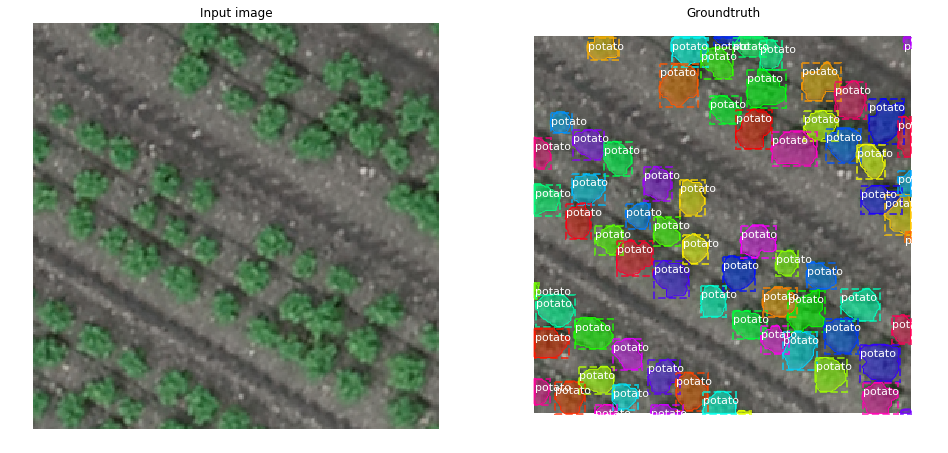

In [10]:
# Test on a  image


image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

axs_=get_ax(rows=1, cols=2, size=8)

axs_[0].imshow(original_image)
axs_[0].set_title('Input image')
axs_[0].axis('off')

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names,ax=axs_[1])

axs_[1].set_title('Groundtruth')

plt.show()

Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  210.00000  int64
molded_images            shape: (1, 256, 256, 3)      min: -113.70000  max:   97.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.13310  max:    1.01299  float32


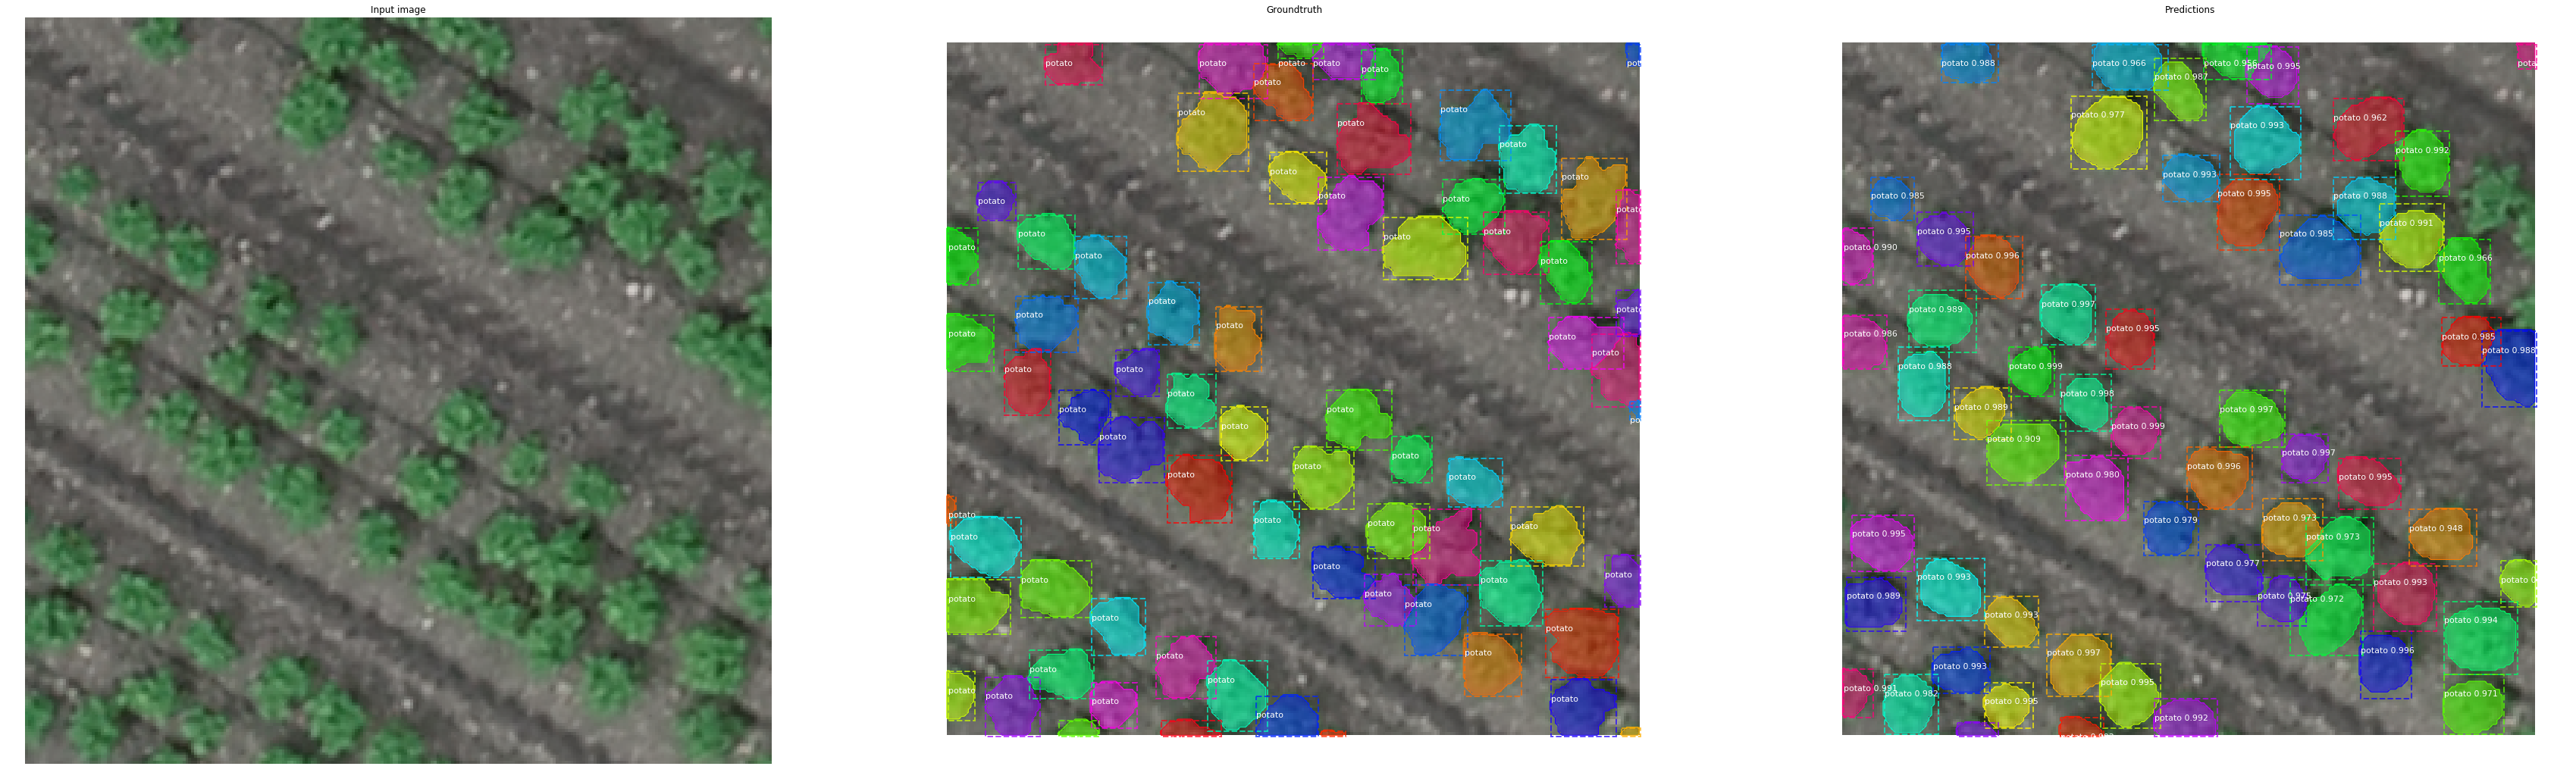

In [11]:
results = model.detect([original_image], verbose=1)


r = results[0]
axs_=get_ax(rows=1, cols=3, size=20)

axs_[0].imshow(original_image)
axs_[0].set_title('Input image')
axs_[0].axis('off')
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names,ax=axs_[1])
axs_[1].set_title('Groundtruth')


visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=axs_[2])
axs_[2].set_title('Predictions')

plt.show()




## Evaluation

In [12]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
# image_ids = np.random.choice(dataset_val.image_ids, 70)
image_ids = dataset_val.image_ids
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.786824613228037


In [13]:
# utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
#                        r['rois'], r['class_ids'], r['scores'], r['masks'],
#                        verbose=1)
